D:\VIT_HACKATHON\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved successfully to network_intrusion_model_DDoS_UDP_Flood.joblib
✅ Model loaded successfully!
Sample predictions made with the loaded model:
[0 0 0 0 0]
Comparison of Actual vs. Predicted Labels:
     Actual Label Predicted Label
0  DDoS-UDP_Flood  DDoS-UDP_Flood
1  DDoS-UDP_Flood  DDoS-UDP_Flood
2  DDoS-UDP_Flood  DDoS-UDP_Flood
3  DDoS-UDP_Flood  DDoS-UDP_Flood
4  DDoS-UDP_Flood  DDoS-UDP_Flood
5  DDoS-UDP_Flood  DDoS-UDP_Flood
6  DDoS-UDP_Flood  DDoS-UDP_Flood
7  DDoS-UDP_Flood  DDoS-UDP_Flood
8  DDoS-UDP_Flood  DDoS-UDP_Flood
9  DDoS-UDP_Flood  DDoS-UDP_Flood

Classification Report:
                precision    recall  f1-score   support

DDoS-UDP_Flood       1.00      1.00      1.00    319329

      accuracy                           1.00    319329
     macro avg       1.00      1.00      1.00    319329
  weighted avg       1.00      1.00      1.00    319329


Confusion Matrix:
[[319329]]


D:\VIT_HACKATHON\venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


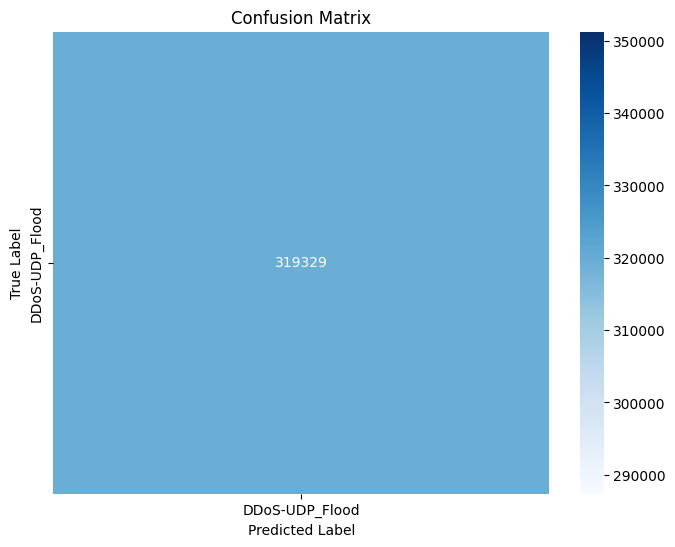


Feature Importances:
                feature  importance
0    num__Header_Length         0.0
1    num__Protocol Type         0.0
2     num__Time_To_Live         0.0
3             num__Rate         0.0
4  num__fin_flag_number         0.0
5  num__syn_flag_number         0.0
6  num__rst_flag_number         0.0
7  num__psh_flag_number         0.0
8  num__ack_flag_number         0.0
9  num__ece_flag_number         0.0


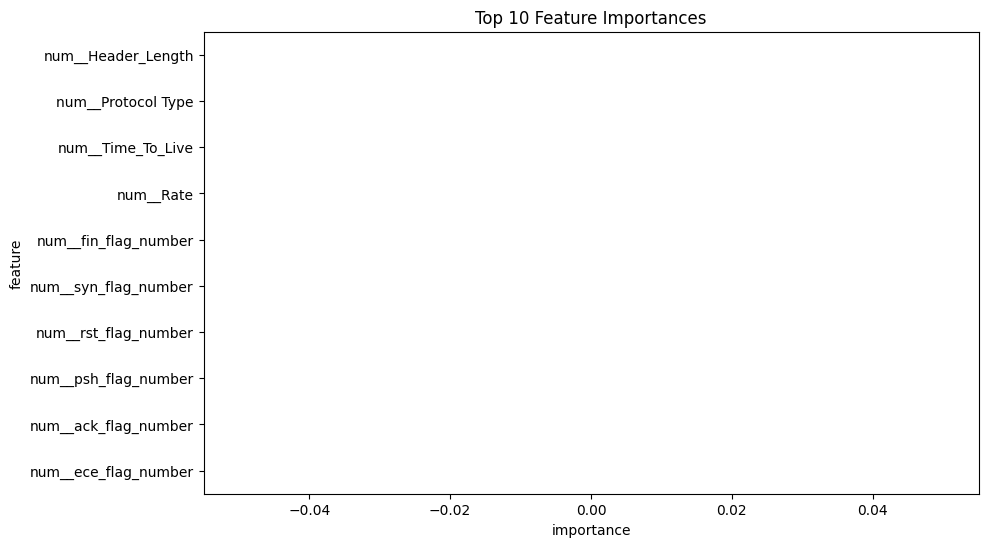

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

df = pd.read_csv('merged_ddos_udp_flood.csv')

X = df.drop('Label', axis=1)
y = df['Label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Protocol Type']

numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
transformers=[
('num', numerical_transformer, numerical_features),
('cat', categorical_transformer, categorical_features)
],
remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

model_pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', base_score=0.5)) # Added base_score
])

model_pipeline.fit(X_train, y_train)

filename = 'network_intrusion_model_DDoS_UDP_Flood.joblib'

joblib.dump(model_pipeline, filename)

print(f"✅ Model saved successfully to {filename}")

loaded_model = joblib.load(filename)

print("✅ Model loaded successfully!")

predictions_numeric = loaded_model.predict(X_test)

probabilities = loaded_model.predict_proba(X_test)

print("Sample predictions made with the loaded model:")
print(predictions_numeric[:5])

predicted_labels = le.inverse_transform(predictions_numeric)
actual_labels = le.inverse_transform(y_test)

comparison_df = pd.DataFrame({
'Actual Label': actual_labels,
'Predicted Label': predicted_labels
})

print("Comparison of Actual vs. Predicted Labels:")
print(comparison_df.head(10))

print("\nClassification Report:")
print(classification_report(y_test, predictions_numeric, target_names=le.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions_numeric)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

xgb_classifier = loaded_model.named_steps['classifier']
feature_names_out = loaded_model.named_steps['preprocessor'].get_feature_names_out()
feature_importances = xgb_classifier.feature_importances_

importance_df = pd.DataFrame({'feature': feature_names_out, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print("\nFeature Importances:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()
